#### Initalise dataset and config object

In [1]:
from config import cfg
from dataset_loaders_refactored import TweetXPriceY, SentimentPriceXPriceY
from torch.utils.data import DataLoader

train_data = cfg.dataloader(
    start_date=cfg.train_start_date,
    end_date=cfg.train_end_date,
    **cfg.dataset_loader_args
)
eval_data = cfg.dataloader(
    start_date=cfg.eval_start_date,
    end_date=cfg.eval_end_date,
    **cfg.dataset_loader_args
)

test_data = cfg.dataloader(
    start_date=cfg.test_start_date,
    end_date=cfg.test_end_date,
    **cfg.dataset_loader_args
)


train_dataloader = DataLoader(train_data, batch_size=cfg.BATCH_SIZE, num_workers=cfg.num_workers, shuffle=True)
eval_dataloader = DataLoader(eval_data, batch_size=cfg.BATCH_SIZE, num_workers=cfg.num_workers,shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=cfg.BATCH_SIZE, num_workers=cfg.num_workers,shuffle=False)



Normalization fitting done for feature Sentiment
Normalization fitting done for feature Twitter_Volume
Normalization fitting done for feature Volume
Normalization fitting done for feature Sentiment
Normalization fitting done for feature Twitter_Volume
Normalization fitting done for feature Volume
Normalization fitting done for feature Sentiment
Normalization fitting done for feature Twitter_Volume
Normalization fitting done for feature Volume


In [2]:
from tqdm import tqdm

inspect_dataset = False
if inspect_dataset:
        for batch_idx, (x, y) in enumerate(tqdm(train_dataloader)):
                input(f'Length train set: {train_data.__len__()}, Length Eval set: {eval_data.__len__()}')
                print(f"Sentiment batch shape: {x[0].size()}")
                print(f"Price Feature batch shape: {x[1].size()}")
                print(f"Labels batch shape: {y.size()}")
                print(x[0], x[1])

## Create the model

In [3]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class RNN_simple(nn.Module):
    def __init__(self) -> None:
        super(RNN_simple, self).__init__()
        #self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=50)
        self.rnn = nn.RNN(input_size=cfg.dataset_loader_args['tweets_per_day']*cfg.dataset_loader_args['words_per_tweet'], hidden_size=cfg.rnn_hidden_size, num_layers=cfg.rnn_hidden_layers, batch_first=True)
        self.fc = nn.Linear(cfg.rnn_hidden_size, 2)

        
    def forward(self, x):
        #x = self.embedding(x)
        h0 = torch.zeros(cfg.rnn_hidden_layers, x.size(0), cfg.rnn_hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]  # Use the output from the last time step
        out = self.fc(out)
        return out
    


class RNN_simple_v2(nn.Module):
    def __init__(self) -> None:
        super(RNN_simple, self).__init__()
        #self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=50)
        self.rnn = nn.RNN(input_size=cfg.dataset_loader_args['tweets_per_day']*cfg.dataset_loader_args['words_per_tweet'], hidden_size=cfg.rnn_hidden_size, num_layers=cfg.rnn_hidden_layers, batch_first=True)
        self.fc = nn.Linear(cfg.rnn_hidden_size, 2)

        
    def forward(self, x):
        #x = self.embedding(x)
        h0 = torch.zeros(cfg.rnn_hidden_layers, x.size(0), cfg.rnn_hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]  # Use the output from the last time step
        out = self.fc(out)
        return out
    



In [4]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class LSTM_v1(nn.Module):
    def __init__(self) -> None:
        super(LSTM_v1, self).__init__()
        #self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=50)
        self.embedding = nn.Embedding(cfg.vocab_size, embedding_dim=128, padding_idx=0)
        #self.rnn = nn.LSTM(input_size=cfg.dataset_loader_args['tweets_per_day']*cfg.dataset_loader_args['words_per_tweet'], hidden_size=cfg.rnn_hidden_size, num_layers=cfg.rnn_hidden_layers, batch_first=True)
        self.lstm = nn.LSTM(
            input_size=128,  # Embedding dimension
            hidden_size=cfg.rnn_hidden_size, 
            num_layers=cfg.rnn_hidden_layers, 
            batch_first=True,
            dropout=0.3
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(cfg.rnn_hidden_size, 2)

        
    def forward(self, x):
        x = x.long()
        x = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
        out, _ = self.lstm(x)  # Shape: (batch_size, seq_length, hidden_size)
        out = self.dropout(out[:, -1, :])  # Use the output from the last time step
        out = self.fc(out)  # Shape: (batch_size, 2)
        return out  # Raw logits
    

from inital_models import Depth_First_GRU2
from models import GRU_Shallow_1fc_AntiOverfit

In [5]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def evaluate_model(dataloader, model):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_logits = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(dataloader)):
            if isinstance(x, list):
                x = [t.to(device) for t in x]
                x = [t.float() for t in x]
                y = y.to(device)
            else:
                x, y = x.to(device), y.to(device)

                x = x.float()
                    #x = x.view(x.size(0), x.size(1), -1)  # Ensure input shape is (batch_size, seq_length, input_size)
                x = x.view(x.size(0), -1)

            outputs = model(x).squeeze()

            outputs = model(x)  # Outputs are raw logits of shape (batch_size, num_classes)
            _, predicted = torch.max(outputs.data, 1)

            

            total += y.size(0)
            correct += (predicted == y).sum().item()

            # Collect data for debugging
            all_logits.append(outputs.cpu())
            all_preds.append(predicted.cpu())
            all_targets.append(y.cpu())

    accuracy = correct / total

    #print(f'Accuracy: {accuracy:.4f}%')

    # Concatenate all the collected and transform to numpy array
    y_hat_logits = torch.cat(all_logits).numpy()
    y_hat = torch.cat(all_preds).numpy()
    y = torch.cat(all_targets).numpy()

    return  accuracy, y, y_hat, y_hat_logits

### Train loop cell

In [6]:

from time import time

model = GRU_Shallow_1fc_AntiOverfit(cfg, test_data.get_input_size())

criterion = cfg.loss_func()
optimizer = cfg.optimizer(model.parameters(), lr=cfg.LEARNING_RATE, weight_decay=1e-4)      #Added weight decay

EPOCHS = cfg.EPOCHS
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

eval_accuracy_across_epochs = []
train_accuracy_across_epochs = []
test_accuracy_across_epochs = []
loss_across_epochs = []
training_time = []

for epoch in range(EPOCHS):
    epoch_start_time = time()
    epoch_loss = 0
    total, correct = 0, 0
    model.train()

    for batch_idx, (x, y) in enumerate(tqdm(train_dataloader)):
        if isinstance(x, list):
            x = [t.to(device) for t in x]
            x = [t.float() for t in x]
            y = y.to(device)
        else:
            x, y = x.to(device), y.to(device)

            x = x.float()
                #x = x.view(x.size(0), x.size(1), -1)  # Ensure input shape is (batch_size, seq_length, input_size)
            x = x.view(x.size(0), -1)

        outputs = model(x).squeeze()
        #Extracting predictions to evaluate test set performance
        _, predicted = torch.max(outputs.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        

        loss = criterion(outputs, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added Gradient clipping
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

         # Print progress
        if (batch_idx + 1) % 100 == 0:
            #print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")
            pass

    epoch_end_time = time()
    training_time.append(epoch_end_time-epoch_start_time)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Average Loss: {epoch_loss/len(train_dataloader):.4f}")

    average_epoch_loss = epoch_loss/len(train_dataloader)
    loss_across_epochs.append(average_epoch_loss)

    #Get accuracy for each epoch on train and eval set
    train_accuracy = correct/total
    eval_accuracy, _, _, _ = evaluate_model(eval_dataloader, model)
    test_accuracy, _, _, _ = evaluate_model(test_dataloader, model)
    model.train()
    print(f'Train Accuracy: {train_accuracy}')
    print(f'Eval Accuracy: {eval_accuracy}')
    print(f'Test Accuracy: {test_accuracy}')
    train_accuracy_across_epochs.append(train_accuracy)
    
    eval_accuracy_across_epochs.append(eval_accuracy)

    test_accuracy_across_epochs.append(test_accuracy)

total_training_time = sum(training_time)
h, rem = divmod(total_training_time, 3600)
m, s = divmod(rem, 60)


log_object = {
    'Dataclass': type(train_data).__name__,
    'Model': type(model).__name__,
    'Report from Training': {
        'training_time': f'{h}h {m}m {s}s',
        'loss_across_epochs': loss_across_epochs,
        'eval_accuracy_per_epoch': eval_accuracy_across_epochs,
        'train_accuracy_per_epoch': train_accuracy_across_epochs,
        'test_accuarcy_per_epoch': test_accuracy_across_epochs
    }
}



100%|██████████| 619/619 [00:15<00:00, 40.28it/s]


Epoch [1/60], Average Loss: 0.6949


100%|██████████| 97/97 [00:02<00:00, 32.58it/s]


Train Accuracy: 0.5086106762284733
Eval Accuracy: 0.44950980392156864
Test Accuracy: 0.47060734004546934


100%|██████████| 619/619 [00:16<00:00, 36.54it/s] 


Epoch [2/60], Average Loss: 0.6938


100%|██████████| 97/97 [00:02<00:00, 33.06it/s]


Train Accuracy: 0.5026513812433715
Eval Accuracy: 0.46225490196078434
Test Accuracy: 0.4761286131860994


100%|██████████| 619/619 [00:17<00:00, 36.28it/s]


Epoch [3/60], Average Loss: 0.6928


100%|██████████| 97/97 [00:02<00:00, 33.25it/s]


Train Accuracy: 0.5180546437048634
Eval Accuracy: 0.4965686274509804
Test Accuracy: 0.5349139330951608


100%|██████████| 619/619 [00:17<00:00, 36.12it/s]


Epoch [4/60], Average Loss: 0.6933


100%|██████████| 97/97 [00:02<00:00, 33.15it/s]


Train Accuracy: 0.5156305237109237
Eval Accuracy: 0.49754901960784315
Test Accuracy: 0.5293926599545307


100%|██████████| 619/619 [00:17<00:00, 36.09it/s]


Epoch [5/60], Average Loss: 0.6923


100%|██████████| 97/97 [00:03<00:00, 31.26it/s] 


Train Accuracy: 0.520680773698298
Eval Accuracy: 0.4852941176470588
Test Accuracy: 0.52029879831114


100%|██████████| 619/619 [00:17<00:00, 35.82it/s]


Epoch [6/60], Average Loss: 0.6921


100%|██████████| 97/97 [00:03<00:00, 32.25it/s]


Train Accuracy: 0.5242664511893339
Eval Accuracy: 0.47794117647058826
Test Accuracy: 0.4822994478726859


100%|██████████| 619/619 [00:17<00:00, 35.56it/s]


Epoch [7/60], Average Loss: 0.6919


100%|██████████| 97/97 [00:02<00:00, 34.51it/s]


Train Accuracy: 0.5219938386950154
Eval Accuracy: 0.4936274509803922
Test Accuracy: 0.5189996752192271


100%|██████████| 619/619 [00:16<00:00, 36.51it/s]


Epoch [8/60], Average Loss: 0.6916


100%|██████████| 97/97 [00:03<00:00, 26.96it/s]


Train Accuracy: 0.5277511236806222
Eval Accuracy: 0.5009803921568627
Test Accuracy: 0.5017862942513803


100%|██████████| 619/619 [00:17<00:00, 35.54it/s]


Epoch [9/60], Average Loss: 0.6913


100%|██████████| 97/97 [00:03<00:00, 31.80it/s]


Train Accuracy: 0.5247209736881976
Eval Accuracy: 0.4872549019607843
Test Accuracy: 0.4913933095160766


100%|██████████| 619/619 [00:17<00:00, 34.72it/s]


Epoch [10/60], Average Loss: 0.6913


100%|██████████| 97/97 [00:03<00:00, 28.24it/s]


Train Accuracy: 0.526589566183526
Eval Accuracy: 0.4872549019607843
Test Accuracy: 0.49886326729457614


100%|██████████| 619/619 [00:20<00:00, 29.74it/s]


Epoch [11/60], Average Loss: 0.6910


100%|██████████| 97/97 [00:03<00:00, 29.11it/s]


Train Accuracy: 0.529165193677087
Eval Accuracy: 0.4843137254901961
Test Accuracy: 0.49074374797012016


100%|██████████| 619/619 [00:17<00:00, 35.16it/s]


Epoch [12/60], Average Loss: 0.6911


100%|██████████| 97/97 [00:03<00:00, 31.99it/s]


Train Accuracy: 0.5281551436796121
Eval Accuracy: 0.49117647058823527
Test Accuracy: 0.4793764209158818


100%|██████████| 619/619 [00:17<00:00, 35.97it/s]


Epoch [13/60], Average Loss: 0.6910


100%|██████████| 97/97 [00:03<00:00, 31.77it/s]


Train Accuracy: 0.5317408211706479
Eval Accuracy: 0.4715686274509804
Test Accuracy: 0.4754790516401429


100%|██████████| 619/619 [00:17<00:00, 34.81it/s]


Epoch [14/60], Average Loss: 0.6909


100%|██████████| 97/97 [00:03<00:00, 30.44it/s]


Train Accuracy: 0.5298722286753195
Eval Accuracy: 0.4980392156862745
Test Accuracy: 0.4871711594673595


100%|██████████| 619/619 [00:18<00:00, 34.07it/s]


Epoch [15/60], Average Loss: 0.6908


100%|██████████| 97/97 [00:03<00:00, 30.79it/s]


Train Accuracy: 0.5305792636735518
Eval Accuracy: 0.47941176470588237
Test Accuracy: 0.48327379019162064


100%|██████████| 619/619 [00:18<00:00, 33.29it/s]


Epoch [16/60], Average Loss: 0.6908


100%|██████████| 97/97 [00:03<00:00, 27.55it/s]


Train Accuracy: 0.5316398161709005
Eval Accuracy: 0.48480392156862745
Test Accuracy: 0.4842481325105554


100%|██████████| 619/619 [00:18<00:00, 32.77it/s]


Epoch [17/60], Average Loss: 0.6908


100%|██████████| 97/97 [00:03<00:00, 32.16it/s]


Train Accuracy: 0.5304782586738044
Eval Accuracy: 0.48480392156862745
Test Accuracy: 0.4917180902890549


100%|██████████| 619/619 [01:35<00:00,  6.45it/s]


Epoch [18/60], Average Loss: 0.6906


100%|██████████| 97/97 [00:03<00:00, 32.31it/s]


Train Accuracy: 0.5276501186808747
Eval Accuracy: 0.4715686274509804
Test Accuracy: 0.49204287106203315


100%|██████████| 619/619 [00:17<00:00, 35.45it/s]


Epoch [19/60], Average Loss: 0.6905


100%|██████████| 97/97 [00:03<00:00, 31.02it/s]


Train Accuracy: 0.5259835361850411
Eval Accuracy: 0.4946078431372549
Test Accuracy: 0.4777525170509906


100%|██████████| 619/619 [00:17<00:00, 34.82it/s]


Epoch [20/60], Average Loss: 0.6903


100%|██████████| 97/97 [00:03<00:00, 30.90it/s]


Train Accuracy: 0.5308317761729205
Eval Accuracy: 0.49166666666666664
Test Accuracy: 0.49723936342968494


100%|██████████| 619/619 [00:19<00:00, 31.50it/s]


Epoch [21/60], Average Loss: 0.6902


100%|██████████| 97/97 [00:03<00:00, 30.63it/s]


Train Accuracy: 0.5299227311751932
Eval Accuracy: 0.4892156862745098
Test Accuracy: 0.4910685287430984


100%|██████████| 619/619 [00:18<00:00, 33.03it/s]


Epoch [22/60], Average Loss: 0.6902


100%|██████████| 97/97 [00:03<00:00, 30.81it/s]


Train Accuracy: 0.529569213676077
Eval Accuracy: 0.5269607843137255
Test Accuracy: 0.52029879831114


100%|██████████| 619/619 [00:19<00:00, 32.09it/s]


Epoch [23/60], Average Loss: 0.6903


100%|██████████| 97/97 [00:03<00:00, 28.72it/s]


Train Accuracy: 0.5318923286702691
Eval Accuracy: 0.47941176470588237
Test Accuracy: 0.48002598246183825


100%|██████████| 619/619 [00:17<00:00, 35.75it/s]


Epoch [24/60], Average Loss: 0.6905


100%|██████████| 97/97 [00:02<00:00, 34.04it/s] 


Train Accuracy: 0.527801626180496
Eval Accuracy: 0.47794117647058826
Test Accuracy: 0.4822994478726859


100%|██████████| 619/619 [01:36<00:00,  6.41it/s]


Epoch [25/60], Average Loss: 0.6905


100%|██████████| 97/97 [-1:58:45<00:00, -1.29it/s]


Train Accuracy: 0.5286096661784758
Eval Accuracy: 0.4936274509803922
Test Accuracy: 0.4894446248782072


100%|██████████| 619/619 [00:18<00:00, 33.07it/s]


Epoch [26/60], Average Loss: 0.6901


100%|██████████| 97/97 [00:03<00:00, 27.67it/s]


Train Accuracy: 0.5297207211756982
Eval Accuracy: 0.5049019607843137
Test Accuracy: 0.49236765183501136


100%|██████████| 619/619 [00:18<00:00, 32.61it/s]


Epoch [27/60], Average Loss: 0.6895


100%|██████████| 97/97 [00:03<00:00, 27.37it/s]


Train Accuracy: 0.5316903186707742
Eval Accuracy: 0.5053921568627451
Test Accuracy: 0.5131536213056187


100%|██████████| 619/619 [00:18<00:00, 33.14it/s]


Epoch [28/60], Average Loss: 0.6899


100%|██████████| 97/97 [00:03<00:00, 31.15it/s]


Train Accuracy: 0.5327003686682491
Eval Accuracy: 0.49117647058823527
Test Accuracy: 0.48457291328353364


100%|██████████| 619/619 [00:17<00:00, 34.44it/s]


Epoch [29/60], Average Loss: 0.6897


100%|██████████| 97/97 [00:03<00:00, 31.50it/s] 


Train Accuracy: 0.5307812736730468
Eval Accuracy: 0.5063725490196078
Test Accuracy: 0.5004871711594674


100%|██████████| 619/619 [00:17<00:00, 34.61it/s]


Epoch [30/60], Average Loss: 0.6894


100%|██████████| 97/97 [00:03<00:00, 31.30it/s]


Train Accuracy: 0.5317913236705217
Eval Accuracy: 0.4843137254901961
Test Accuracy: 0.4933419941539461


100%|██████████| 619/619 [00:17<00:00, 34.77it/s]


Epoch [31/60], Average Loss: 0.6898


100%|██████████| 97/97 [00:03<00:00, 29.26it/s]


Train Accuracy: 0.5323468511691328
Eval Accuracy: 0.5034313725490196
Test Accuracy: 0.4982137057486197


100%|██████████| 619/619 [00:18<00:00, 33.30it/s] 


Epoch [32/60], Average Loss: 0.6899


100%|██████████| 97/97 [00:03<00:00, 28.35it/s]


Train Accuracy: 0.5320438361698904
Eval Accuracy: 0.4676470588235294
Test Accuracy: 0.4732055862292952


100%|██████████| 619/619 [00:18<00:00, 34.26it/s]


Epoch [33/60], Average Loss: 0.6898


100%|██████████| 97/97 [00:03<00:00, 31.14it/s]


Train Accuracy: 0.5315893136710267
Eval Accuracy: 0.4852941176470588
Test Accuracy: 0.49561545956479375


 78%|███████▊  | 485/619 [00:15<00:04, 31.31it/s]


KeyboardInterrupt: 

## Logging cell

In [ ]:
import os
import json
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



test_accuracy, y, y_hat, y_hat_logits = evaluate_model(test_dataloader, model)
accuracy_train, _, _, _ = evaluate_model(train_dataloader, model)
accuracy_eval, _, _, _ = evaluate_model(eval_dataloader, model)


F1 = f1_score(y, y_hat)
precision = precision_score(y, y_hat)
recall = recall_score(y, y_hat)

log_object['Results'] = {
    'accuracy_test': test_accuracy,
    'accuracy_eval': accuracy_eval,
    'accuracy_train': accuracy_train,
    'F1_eval': F1,
    'precision_eval': precision,
    'recall_eval': recall,
    'y_eval': y.tolist(),
    'y_hat_eval': y_hat.tolist(),
    'y_hat_logits_eval': y_hat_logits.tolist()
}





100%|██████████| 64/64 [00:02<00:00, 26.61it/s]


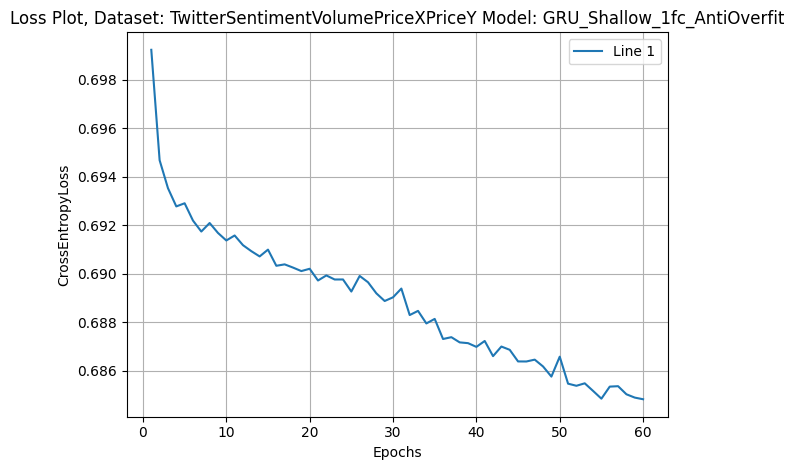

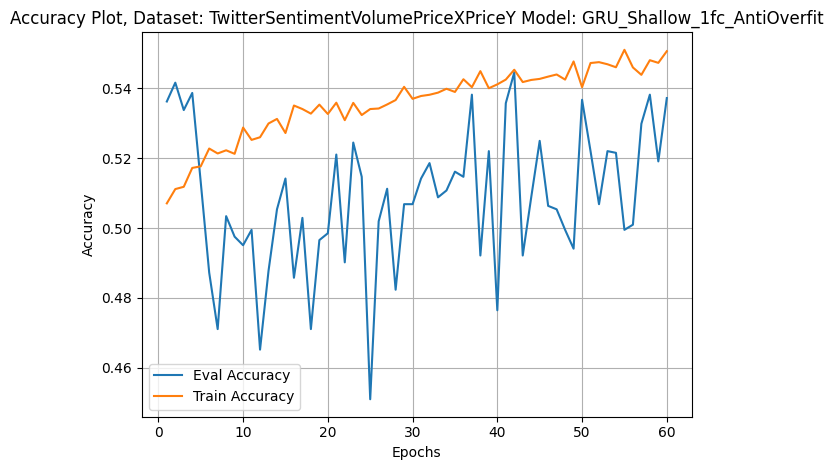

In [ ]:
def write_log_to_file(experiment_name:str, log_obj:dict):
    '''experiment_name is the name the file will be stored with. Suggested as f"model_{model_class}_dataset_{dataset_class}". The name gets "_{id}.json" appended'''
    root = 'results_final_day/'
    result_dir = os.path.join(root, experiment_name)

    if not result_dir.split('/')[-1] in os.listdir(root):
        os.makedirs(result_dir)

    #Create new id with 4 digits incrementally
    dir_ids = [int(path.split(".")[-2].split('_')[0]) for path in os.listdir(result_dir)]
    new_id = str(max(dir_ids)+ 1) if len(dir_ids) > 0 else '0'     #Increment max id by 1 or set to 0 if no id present
    id = '0'*(4-len(new_id)) + new_id    #Make id 4 digits

    target_file = os.path.join(result_dir, f'{id}.json')
    with open(target_file, 'w') as f:
        json.dump(log_obj, f, indent=4)
    
    return target_file

import inspect
def log_config(log_object, config):
    config_to_log = {}
    for key, value in vars(config).items():
        #print(key, inspect.isclass(value), inspect.isfunction(value))
        if inspect.isclass(value) or inspect.isfunction(value): #or isinstance(value, types.FunctionType):  # Check if it's a class instance
            config_to_log[key] = value.__name__  # Log the class name
            #print(config_to_log[key])
        elif isinstance(value, np.ndarray):
            config_to_log[key] = value.tolist()
        else:
            config_to_log[key] = value  # Log the value directly for primitive types
    log_object['Config'] = config_to_log
    #Rearrange dict so config comes after dataset and model
    log_object = {k: log_object[k] for k in list(log_object.keys())[:2] + ['Config'] + list(log_object.keys())[2:-1]}
    return log_object


log_object = log_config(log_object, cfg)

created_file_path = write_log_to_file(f"model_{type(model).__name__}_dataset_{type(train_data).__name__}", log_object)

from result_dataprocessing import generate_training_plot_from_file

generate_training_plot_from_file(created_file_path)

## Hyper Parameter Tuning